In [1]:
import h5py
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap']='jet'
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path
from MD_AE_tools.mode_decomposition import POD


import tensorflow as tf
tf.keras.backend.set_floatx('float32')
import configparser
import MD_AE_tools.ae_mode_evaluation as mode_eval
mse = tf.keras.losses.MeanSquaredError()
import MD_AE_tools.models.models_ff as modelff

from scipy import interpolate
from matplotlib import mlab
from tensorflow.keras.callbacks import ModelCheckpoint
# from MD_AE_tools.models.models import *
from MD_AE_tools.models.models_no_bias import *
from MD_AE_tools.models import model_evaluation
from MD_AE_tools.ae_mode_evaluation import equivalent_pca_energy
from project_specific_utils import read_pressure
from project_specific_utils.read_pressure import PIVdata
from numpy import einsum
config = configparser.ConfigParser()
config.read('_system.ini')
system_info = config['system_info']
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[2], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        tf.config.set_logical_device_configuration(gpus[2],[tf.config.LogicalDeviceConfiguration(memory_limit=20000)]) # set hard memory limit
        # tf.config.experimental.set_memory_growth(gpus[2], True) # allow memory growth
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPU


In [2]:
# which_sets = [PIVdata.PIV7, PIVdata.PIV9, PIVdata.PIV12, PIVdata.PIV17]

# with h5py.File('./data/raw_pressure.h5','r') as hf:
#     print(hf.keys())
#     dt = np.squeeze(hf.get('dt'))
#     static_p = np.squeeze(hf.get('static_p'))
#     esp = np.array(hf.get('esp')).T
#     r = np.array(hf.get('r')).T
#     theta = np.array(hf.get('theta')).T
with h5py.File('./data/raw_pressure_long.h5','r') as hf:
    print(hf.keys())
    fs = np.squeeze(hf.get('fs'))
    static_p = np.squeeze(hf.get('static_p'))
    esp = np.array(hf.get('esp')).T
    r = np.array(hf.get('r')).T
    theta = np.array(hf.get('theta')).T


x=(np.cos(theta*np.pi/180).T)*r
y=(np.sin(theta*np.pi/180).T)*r 
x = x.flatten()
y = y.flatten()

## Parameters
nfft_psd = 2**14
overlap = nfft_psd/2
sampling_freq = fs
# sampling_freq = 720
# num_of_tests = len(which_sets)
D = 196.5 #mm
Uinf = 15 #m/s

# esp_allt = np.concatenate(esp[which_sets,:,:],axis=1)
esp_allt = esp
pmean = np.mean(esp_allt,axis=1).reshape(8,8)
prms = np.std(esp_allt,axis=1)
esp_allt.shape

<KeysViewHDF5 ['esp', 'fs', 'r', 'static_p', 'theta']>


(64, 4320000)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[[ 0.0004655  -0.00062117]]


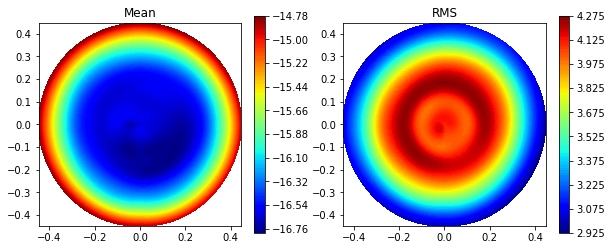

In [3]:
print(read_pressure.cop(pmean.reshape(-1,1)))
x_interp,y_interp,pmean_interp = read_pressure.interp(pmean,nint=15,filter=False)
_,_,prms_interp = read_pressure.interp(prms,nint=15,filter=False)

plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
im1 = ax1.contourf(x_interp,y_interp,pmean_interp,levels=100,cmap='jet')
ax1.set_aspect('equal')
ax1.set_title('Mean')
plt.colorbar(im1,ax=ax1)

ax2 = plt.subplot(122)
im1 = ax2.contourf(x_interp,y_interp,prms_interp,levels=100,cmap='jet')
ax2.set_aspect('equal')
ax2.set_title('RMS')
plt.colorbar(im1,ax=ax2)

plt.show()

In [4]:
pod_data = POD(esp_allt)
modes,lam = pod_data.get_modes
a = pod_data.get_time_coefficient
_mean = np.mean(esp_allt,axis=1,keepdims=True)
num_modes = 5
reconstructed_pod = pod_data.reconstruct(num_modes)
print(f'Reconstruct with {num_modes} POD modes gives MSE {mse(reconstructed_pod-_mean,esp_allt-_mean)}')

Calculating POD ...
Use classic POD, Nx <= Nt.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


POD done.
Returning temporal coefficients for classic POD.
Returning temporal coefficients for classic POD.
Reconstruct with 5 POD modes gives MSE 2.9244415760040283


In [5]:
rel_l2 = (np.sum((reconstructed_pod-_mean - (esp_allt-_mean))**2) / np.sum((esp_allt-_mean)**2))**0.5
print('relative error (no mean): ', rel_l2)

relative error (no mean):  0.44925980350282224


### Data frequency

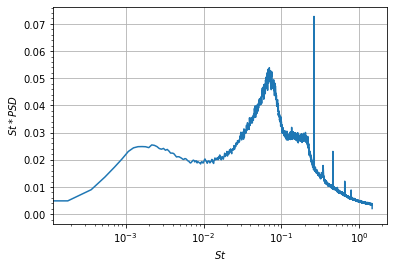

In [6]:
(nx,nt) = esp_allt.shape

pfluc = esp_allt - np.mean(esp_allt,axis=1,keepdims=True)
spp,freqs = mlab.psd(pfluc[0,:],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
st = (D/1000/Uinf)*freqs
for i in range(1,nx):
    spp1,_ = mlab.psd(pfluc[i,:],Fs=fs,NFFT=nfft_psd,noverlap=overlap)
    spp = spp + spp1
spp = spp/nx
    
plt.figure()

plt.semilogx(st, st*spp)

plt.xlabel('$St$')
plt.ylabel('$St*PSD$')
plt.minorticks_on()
plt.grid(axis='both')
plt.show()

# Nz

In [8]:
with h5py.File('./_results/find_latent_dim_2to10.h5') as hf:
    loss_history = np.array(hf.get('loss_history'))
    loss_best = np.array(hf.get('loss_best'))
    latent_dim_list = list(hf.get('latent_dim_list'))
with h5py.File('./_results/find_latent_dim_16to24.h5') as hf:
    loss_history1 = np.array(hf.get('loss_history'))
    loss_best1 = np.array(hf.get('loss_best'))
    latent_dim_list1 = list(hf.get('latent_dim_list'))
loss_history = np.concatenate((loss_history,loss_history1),axis=0)
loss_best = np.concatenate((loss_best,loss_best1),axis=0)
latent_dim_list.extend(latent_dim_list1)
with h5py.File('./_results/find_latent_dim_4.h5') as hf:
    loss_history1 = np.array(hf.get('loss_history'))
    loss_best1 = np.array(hf.get('loss_best'))
    latent_dim_list1 = list(hf.get('latent_dim_list'))
loss_history = np.concatenate((loss_history[:,:,:4000],loss_history1),axis=0)
loss_best = np.concatenate((loss_best,loss_best1),axis=0)
latent_dim_list.extend(latent_dim_list1)
# with h5py.File('./_results/find_latent_dim_24.h5') as hf:
#     loss_history1 = np.array(hf.get('loss_history'))
#     loss_best1 = np.array(hf.get('loss_best'))
#     latent_dim_list1 = list(hf.get('latent_dim_list'))
# loss_history = np.concatenate((loss_history,loss_history1),axis=0)
# loss_best = np.concatenate((loss_best,loss_best1),axis=0)
# latent_dim_list.extend(latent_dim_list1)


In [9]:
idx = np.argsort(latent_dim_list)
latent_dim_list = np.sort(latent_dim_list)
loss_best = loss_best[idx]
loss_history = loss_history[idx]
loss_std = np.std(loss_best,axis=1)
loss_mean = np.mean(loss_best,axis=1)
print('Nz tested: ',latent_dim_list)
print('Mean loss for each Nz: ',loss_mean)

Nz tested:  [ 2  3  4  5 10 16 19 20 24]
Mean loss for each Nz:  [5.26537609 3.74060019 3.21441086 3.87305125 1.34590737 0.91530879
 0.72366152 0.74816034 0.54983566]


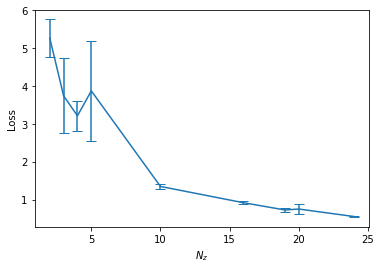

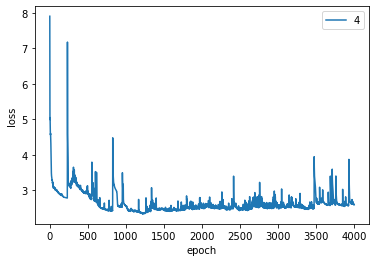

In [13]:
plt.figure()
ax = plt.subplot(111)
ax.errorbar(latent_dim_list,loss_mean,yerr=loss_std,capsize=5)
ax.set_xlabel('$N_z$')
ax.set_ylabel('Loss')
# ax.set_yscale('log')


which_nz = 2
plt.figure()
plt.plot(loss_history[which_nz,1,:],label=str(latent_dim_list[which_nz])) #loss_history [nz,repeat,:]
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

# Model
Model parameters

In [14]:
[n,nt] = esp_allt.shape

## ae configuration
lmb = 0.0000 #1e-05 #regulariser
drop_rate = 0.0
act_fct = 'tanh'
batch_norm = True

## feedforward ae configuration
input_shape = n
encoder_layers = [128,256,256,128,64]
decoder_layers = [64,128,256,256,128]


## training
nb_epoch = 3000
batch_size = 200000
learning_rate = 0.004


p_train = esp_allt - pmean.flatten()[:,np.newaxis]
p_train = p_train.T

In [16]:
lrschedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    learning_rate,
    100,
    t_mul=50,
    m_mul=0.9,
)

# AE

In [64]:
latent_dim = 4

ae = modelff.Autoencoder(
    input_shape = input_shape,
    encoder_layers = encoder_layers,
    decoder_layers = decoder_layers,
    latent_dim = latent_dim,
    act_fct = act_fct,
    batch_norm = batch_norm,
    drop_rate = drop_rate,
    lmb = lmb
)
ae.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 64)]              0         
                                                                 
 encoder_3 (Encoder)         (None, 4)                 151040    
                                                                 
 decoder_3 (Decoder)         (None, 64)                151040    
                                                                 
Total params: 302,080
Trainable params: 298,752
Non-trainable params: 3,328
_________________________________________________________________


In [65]:
ae.compile(optimizer=Adam(learning_rate=lrschedule),loss='mse',run_eagerly=False)
ae.fit(p_train,p_train,batch_size=batch_size,epochs=100)

Epoch 1/100
22/22 [==============================] - 6s 159ms/step - loss: 8.1654
Epoch 2/100
22/22 [==============================] - 4s 158ms/step - loss: 5.2796
Epoch 3/100
22/22 [==============================] - 4s 159ms/step - loss: 5.0441
Epoch 4/100
22/22 [==============================] - 5s 211ms/step - loss: 4.9262
Epoch 5/100
22/22 [==============================] - 3s 158ms/step - loss: 5.0981
Epoch 6/100
22/22 [==============================] - 4s 187ms/step - loss: 4.9620
Epoch 7/100
22/22 [==============================] - 4s 191ms/step - loss: 4.6962
Epoch 8/100
22/22 [==============================] - 3s 157ms/step - loss: 4.6337
Epoch 9/100
22/22 [==============================] - 4s 181ms/step - loss: 4.5973
Epoch 10/100
22/22 [==============================] - 3s 158ms/step - loss: 4.5631
Epoch 11/100
22/22 [==============================] - 3s 157ms/step - loss: 4.5584
Epoch 12/100
22/22 [==============================] - 3s 157ms/step - loss: 4.5816
Epoch 13/100


In [54]:
ae.compile(optimizer=Adam(learning_rate=lrschedule),loss='mse',run_eagerly=False)
ae.evaluate(p_train[:10,:],p_train[:10,:])
# ae.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')
ae.load_weights('temp_weights_2to10.h5')

1/1 [==============================] - 0s 369ms/step - loss: 8.4209


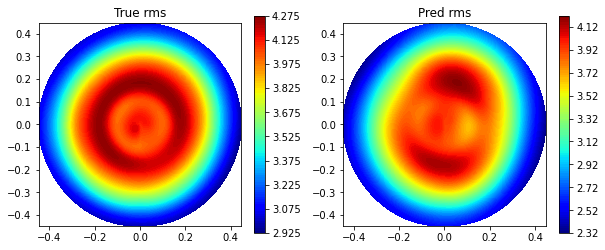

relative error:  0.5014874268436115
MSE:  3.6439168


In [66]:
pred = ae.predict(p_train,batch_size=batch_size).T
pred_rms = np.std(pred,axis=1)
x_interp,y_interp,prms_interp = read_pressure.interp(prms,nint=15,filter=False)
_,_,pred_rms_interp = read_pressure.interp(pred_rms,nint=15,filter=False)

plt.figure(figsize=(10,4))
ax1 = plt.subplot(121)
im1 = ax1.contourf(x_interp,y_interp,prms_interp,levels=100,cmap='jet')
ax1.set_aspect('equal')
ax1.set_title('True rms')
plt.colorbar(im1,ax=ax1)

ax2 = plt.subplot(122)
im1 = ax2.contourf(x_interp,y_interp,pred_rms_interp,levels=100,cmap='jet')
ax2.set_aspect('equal')
ax2.set_title('Pred rms')
plt.colorbar(im1,ax=ax2)

plt.show()

rel_l2 = (np.sum((pred - p_train.T)**2) / np.sum(p_train.T**2))**0.5
error = np.mean((pred - p_train.T)**2)
print('relative error: ', rel_l2)
print('MSE: ', error)

# Basic analysis

In [67]:
pred_ae = ae.predict(p_train,batch_size=batch_size)
z_ae = ae.encoder.predict(p_train, batch_size=batch_size)

/tmp/ipykernel_3173893/2531828915.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/ym917/miniconda3/envs/MD-CNN-AE/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


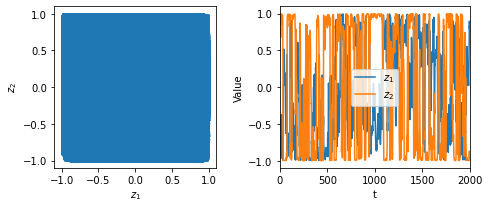

In [68]:
fig,axes = plt.subplots(1,2,figsize=(7,3))
axes[0].scatter(z_ae[:,0],z_ae[:,1],s=1)
axes[0].set(aspect='equal',xlabel='$z_1$',ylabel='$z_2$')
axes[1].plot(z_ae[:,0],label='$z_1$')
axes[1].plot(z_ae[:,2],label='$z_2$')
axes[1].set(xlabel='t',ylabel='Value')
axes[1].legend()
axes[1].set(xlim=[0,2000])
# axes[0].set(xlim=[0.5,1.0], ylim=[-1.0,-0.3])
plt.tight_layout()
# plt.savefig('_plots/ae_cylinder2_latentbasic.pdf')
plt.show()

In [61]:
z_ae.shape

(4320000, 10)

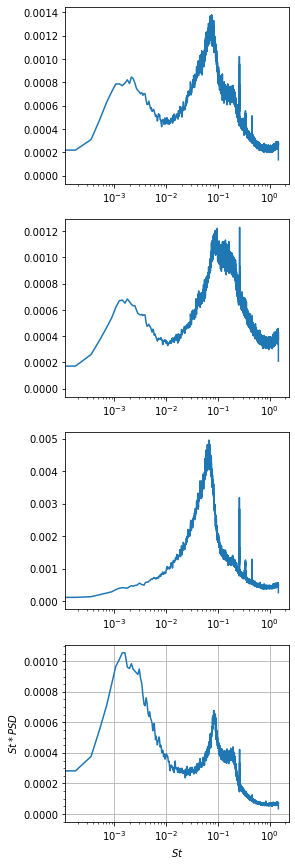

In [69]:
_n = min(latent_dim,5)
fig, axes = plt.subplots(_n,1,figsize=(4,15))

for i in range(_n):
    
    spp,freqs = mlab.psd(z_ae[:,i],Fs=fs,NFFT=nfft_psd,noverlap=overlap)

    axes[i].semilogx(st, st*spp, label=f'z{i}')

plt.xlabel('$St$')
plt.ylabel('$St*PSD$')
plt.minorticks_on()
plt.grid(axis='both')
plt.show()